In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Load the datasets
train_df = pd.read_csv('/content/drive/My Drive/Drug review/drugsComTrain_raw.csv')
test_df = pd.read_csv('/content/drive/My Drive/Drug review/drugsComTest_raw.csv')

# Clean the text data
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['review'] = train_df['review'].apply(clean_text)
test_df['review'] = test_df['review'].apply(clean_text)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(train_df['review'])

train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])

max_len = 200
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Encode labels for condition (for classification tasks)
label_encoder = LabelEncoder()

# Fit the label encoder on combined train and test data to ensure consistency
combined_conditions = pd.concat([train_df['condition'], test_df['condition']], axis=0)
label_encoder.fit(combined_conditions)

# Encode conditions in both train and test sets
train_df['condition_encoded'] = label_encoder.transform(train_df['condition'])
test_df['condition_encoded'] = label_encoder.transform(test_df['condition'])

# # Save processed data
train_df.to_csv('processed_train_drug_reviews.csv', index=False)
test_df.to_csv('processed_test_drug_reviews.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Label sentiment
train_df['sentiment'] = train_df['rating'].apply(lambda x: 2 if x > 7 else (1 if x > 4 else 0))
test_df['sentiment'] = test_df['rating'].apply(lambda x: 2 if x > 7 else (1 if x > 4 else 0))

# Prepare data
y_train_sentiment = to_categorical(train_df['sentiment'])
y_test_sentiment = to_categorical(test_df['sentiment'])

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train_sentiment, epochs=1, batch_size=256, validation_data=(X_test, y_test_sentiment))

631/631 [==============================] - 1461s 2s/step - loss: 0.6678 - accuracy: 0.7317 - val_loss: 0.6125 - val_accuracy: 0.7553


In [ ]:
# Prepare data
y_train_ratings = train_df['rating'].values
y_test_ratings = test_df['rating'].values

# Build LSTM model for regression
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
model.fit(X_train, y_train_ratings, epochs=1, batch_size=256, validation_data=(X_test, y_test_ratings))

631/631 [==============================] - 1488s 2s/step - loss: 9.0111 - mae: 2.4195 - val_loss: 6.0530 - val_mae: 1.8921


In [ ]:
import gensim
from gensim import corpora

# Prepare data for LDA
tokenized_reviews = [review.split() for review in train_df['review']]
dictionary = corpora.Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Train LDA model
lda_model = gensim.models.LdaMulticore(corpus, num_topics=5, id2word=dictionary, passes=10, workers=2)

# Print the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(0, '0.030*"039" + 0.029*"pain" + 0.016*"day" + 0.014*"take" + 0.010*"took"')
(1, '0.020*"side" + 0.017*"effects" + 0.015*"years" + 0.011*"039" + 0.009*"blood"')
(2, '0.042*"039" + 0.012*"anxiety" + 0.010*"feel" + 0.010*"taking" + 0.009*"side"')
(3, '0.055*"039" + 0.017*"period" + 0.015*"pill" + 0.012*"months" + 0.011*"control"')
(4, '0.038*"039" + 0.012*"skin" + 0.009*"acne" + 0.008*"using" + 0.008*"day"')


In [ ]:
# Prepare data
y_train_conditions = to_categorical(train_df['condition_encoded'])
y_test_conditions = to_categorical(test_df['condition_encoded'])

# Build LSTM model for classification
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train_conditions, epochs=1, batch_size=256, validation_data=(X_test, y_test_conditions))

631/631 [==============================] - 1499s 2s/step - loss: 4.4696 - accuracy: 0.1781 - val_loss: 4.3772 - val_accuracy: 0.1794


In [ ]:
# Prepare data
y_train_helpful = train_df['usefulCount'].values
y_test_helpful = test_df['usefulCount'].values

# Build LSTM model for regression
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
model.fit(X_train, y_train_helpful, epochs=1, batch_size=256, validation_data=(X_test, y_test_helpful))

631/631 [==============================] - 1488s 2s/step - loss: 1398.4102 - mae: 22.5255 - val_loss: 1308.5048 - val_mae: 23.5201


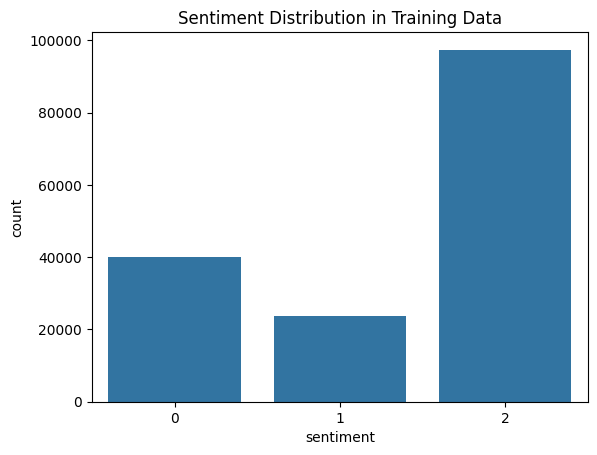

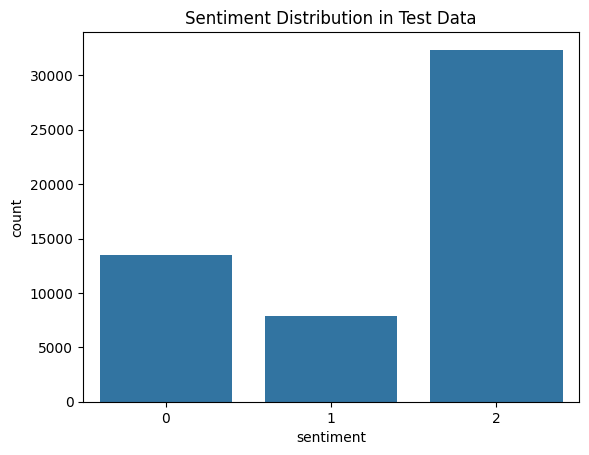

1681/1681 [==============================] - 259s 153ms/step


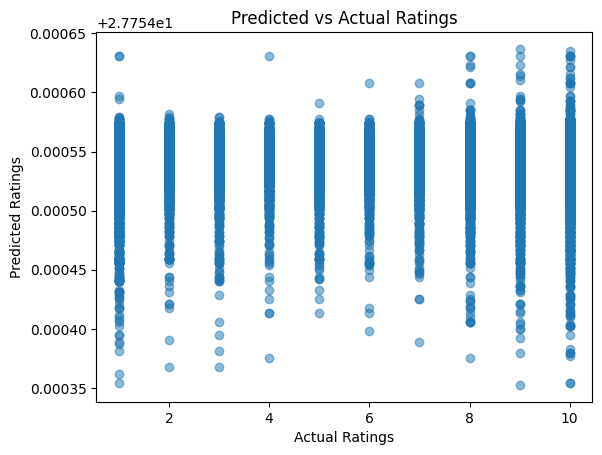

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution in Training Data')
plt.show()

sns.countplot(x='sentiment', data=test_df)
plt.title('Sentiment Distribution in Test Data')
plt.show()

# Predicted vs Actual Ratings
predicted_ratings = model.predict(X_test).flatten()
plt.scatter(y_test_ratings, predicted_ratings, alpha=0.5)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')
plt.show()

# Common Topics
for topic in topics:
    print(topic)

In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import nltk
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Load pre-trained models and data
def load_data():
    # Load processed data
    train_df = pd.read_csv('processed_train_drug_reviews.csv')
    test_df = pd.read_csv('processed_test_drug_reviews.csv')

    # Load tokenizer
    tokenizer = Tokenizer(num_words=20000)
    tokenizer.fit_on_texts(train_df['review'])

    # Load label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load('label_encoder_classes.npy', allow_pickle=True)

    return train_df, test_df, tokenizer, label_encoder

def load_lda_model():
    # Load LDA model and dictionary
    dictionary = corpora.Dictionary.load('lda_dictionary.gensim')
    lda_model = gensim.models.LdaMulticore.load('lda_model.gensim')

    return dictionary, lda_model

def load_lstm_model(model_path):
    # Load LSTM model
    model = load_model(model_path)
    return model

# Function to preprocess user input
def preprocess_input(text, tokenizer, max_len):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    sequence = tokenizer.texts_to_sequences([' '.join(tokens)])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

# Function to predict sentiment
def predict_sentiment(text, model, tokenizer, max_len):
    preprocessed_text = preprocess_input(text, tokenizer, max_len)
    sentiment = model.predict(preprocessed_text)
    sentiment_label = np.argmax(sentiment)
    return sentiment_label

# Function to predict drug conditions and reviews
def predict_drug_info(drug_name, train_df, test_df, model, tokenizer, max_len, label_encoder, dictionary, lda_model):
    # Find conditions of the drug usage
    conditions = train_df[train_df['drugName'].str.lower() == drug_name.lower()]['condition'].unique()

    # Find associated reviews and their ratings
    reviews = test_df[test_df['drugName'].str.lower() == drug_name.lower()].head(5)[['review', 'rating']]

    # Predict conditions based on reviews
    reviews['sentiment'] = reviews['review'].apply(lambda x: predict_sentiment(x, model, tokenizer, max_len))
    reviews['sentiment_label'] = reviews['sentiment'].apply(lambda x: label_encoder.classes_[x])

    # Topic modeling on reviews
    tokenized_reviews = [review.split() for review in reviews['review']]
    bow_corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]
    topics = lda_model.show_topics(num_topics=3, num_words=3)

    return conditions, reviews, topics

# Load data and models
train_df, test_df, tokenizer, label_encoder = load_data()
dictionary, lda_model = load_lda_model()
lstm_model = load_lstm_model('sentiment_analysis_model.h5')

# Example usage of the functions
def main():
    while True:
        print("\nWelcome to Drug Review Analysis System!")
        print("1. Analyze Sentiment of a Review")
        print("2. Get Drug Information")
        print("3. Exit")
        choice = input("Enter your choice (1/2/3): ")

        if choice == '1':
            review_text = input("Enter your review text: ")
            sentiment_label = predict_sentiment(review_text, lstm_model, tokenizer, 200)
            sentiment = label_encoder.classes_[sentiment_label]
            print(f"Predicted Sentiment: {sentiment}")

        elif choice == '2':
            drug_name = input("Enter the name of the drug: ")
            conditions, reviews, topics = predict_drug_info(drug_name, train_df, test_df, lstm_model, tokenizer, 200, label_encoder, dictionary, lda_model)

            print(f"\nConditions for using {drug_name}:")
            for condition in conditions:
                print(f"- {condition}")

            print(f"\nSome Reviews for {drug_name}:")
            for index, row in reviews.iterrows():
                print(f"Review {index + 1}:")
                print(f"Rating: {row['rating']}")
                print(f"Sentiment: {row['sentiment_label']}")
                print(f"Review: {row['review']}")
                print()

            print("Topics in Reviews:")
            for topic in topics:
                print(topic)

        elif choice == '3':
            print("Exiting the program...")
            break

        else:
            print("Invalid choice. Please enter 1, 2, or 3.")

if __name__ == "__main__":
    main()

(0, '0.030*"039" + 0.029*"pain" + 0.016*"day" + 0.014*"take" + 0.010*"took"')
(1, '0.020*"side" + 0.017*"effects" + 0.015*"years" + 0.011*"039" + 0.009*"blood"')
(2, '0.042*"039" + 0.012*"anxiety" + 0.010*"feel" + 0.010*"taking" + 0.009*"side"')
(3, '0.055*"039" + 0.017*"period" + 0.015*"pill" + 0.012*"months" + 0.011*"control"')
(4, '0.038*"039" + 0.012*"skin" + 0.009*"acne" + 0.008*"using" + 0.008*"day"')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


AttributeError: 'float' object has no attribute 'lower'